# 

In [3]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

data_folder = "/kaggle/input/cmap-set/CMaps"

columns = (
    ["engine_id", "time_in_cycles"] +          
    [f"op_setting_{i}" for i in range(1, 4)] + 
    [f"sensor_{i}" for i in range(1, 22)]
)

train_files = [f for f in os.listdir(data_folder) if f.startswith("train")]

def load_cmaps_data(filename):
    file_path = os.path.join(data_folder, filename)
    df = pd.read_csv(file_path, sep=r"\s+", header=None, names=columns, engine="python")
    return df

df_FD001_train = load_cmaps_data("train_FD001.txt")



max_cycles_train = df_FD001_train.groupby("engine_id")["time_in_cycles"].max()
df_FD001_train = df_FD001_train.merge(max_cycles_train.rename("max_cycles"), on="engine_id")
df_FD001_train["RUL"] = df_FD001_train["max_cycles"] - df_FD001_train["time_in_cycles"]
df_FD001_train.drop(columns=["max_cycles"], inplace=True)

print("First few rows with RUL computed:")
print(df_FD001_train.head())

import pandas as pd
from sklearn.model_selection import train_test_split

engine_life = df_FD001_train.groupby("engine_id")["time_in_cycles"].max().reset_index()
engine_life.columns = ["engine_id", "max_cycle"]

engine_life["life_bin"] = pd.qcut(engine_life["max_cycle"], q=4, duplicates="drop")

train_engine_ids, val_engine_ids = train_test_split(
    engine_life["engine_id"],
    test_size=0.2,
    random_state=42,
    stratify=engine_life["life_bin"]
)

df_train_engine_level = df_FD001_train[df_FD001_train["engine_id"].isin(train_engine_ids)]
df_val_engine_level   = df_FD001_train[df_FD001_train["engine_id"].isin(val_engine_ids)]

print(f"Number of engines in training set: {df_train_engine_level['engine_id'].nunique()}")
print(f"Number of rows in training set: {df_train_engine_level.shape[0]}")
print(f"Number of engines in validation set: {df_val_engine_level['engine_id'].nunique()}")
print(f"Number of rows in validation set: {df_val_engine_level.shape[0]}")


First few rows with RUL computed:
   engine_id  time_in_cycles  op_setting_1  op_setting_2  op_setting_3  \
0          1               1       -0.0007       -0.0004         100.0   
1          1               2        0.0019       -0.0003         100.0   
2          1               3       -0.0043        0.0003         100.0   
3          1               4        0.0007        0.0000         100.0   
4          1               5       -0.0019       -0.0002         100.0   

   sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  ...  sensor_13  \
0    518.67    641.82   1589.70   1400.60     14.62  ...    2388.02   
1    518.67    642.15   1591.82   1403.14     14.62  ...    2388.07   
2    518.67    642.35   1587.99   1404.20     14.62  ...    2388.03   
3    518.67    642.35   1582.79   1401.87     14.62  ...    2388.08   
4    518.67    642.37   1582.85   1406.22     14.62  ...    2388.04   

   sensor_14  sensor_15  sensor_16  sensor_17  sensor_18  sensor_19  \
0    8138.62     8.4195

Fold 1: TRAIN RMSE = 35.89, VAL RMSE = 50.66
Fold 2: TRAIN RMSE = 35.98, VAL RMSE = 49.85
Fold 3: TRAIN RMSE = 37.17, VAL RMSE = 40.35
Fold 4: TRAIN RMSE = 36.18, VAL RMSE = 48.70
Fold 5: TRAIN RMSE = 37.91, VAL RMSE = 32.24
Fold 6: TRAIN RMSE = 37.79, VAL RMSE = 33.56
Fold 7: TRAIN RMSE = 36.69, VAL RMSE = 43.83
Fold 8: TRAIN RMSE = 37.54, VAL RMSE = 36.95
Fold 9: TRAIN RMSE = 36.97, VAL RMSE = 40.66
Fold 10: TRAIN RMSE = 36.95, VAL RMSE = 41.26
Average TRAIN RMSE across folds: 36.91
Average VAL   RMSE across folds: 41.81


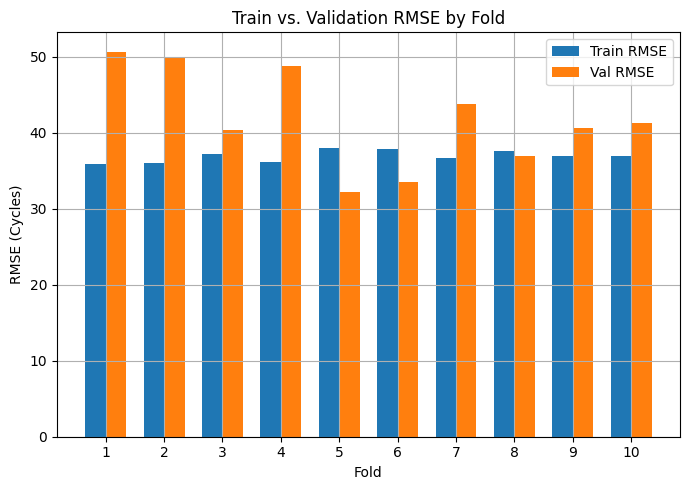


Final Out-of-Fold RMSE (all data): 42.26


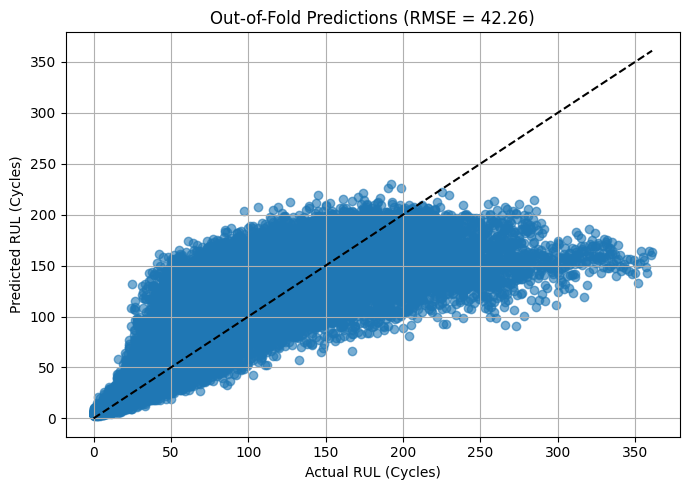

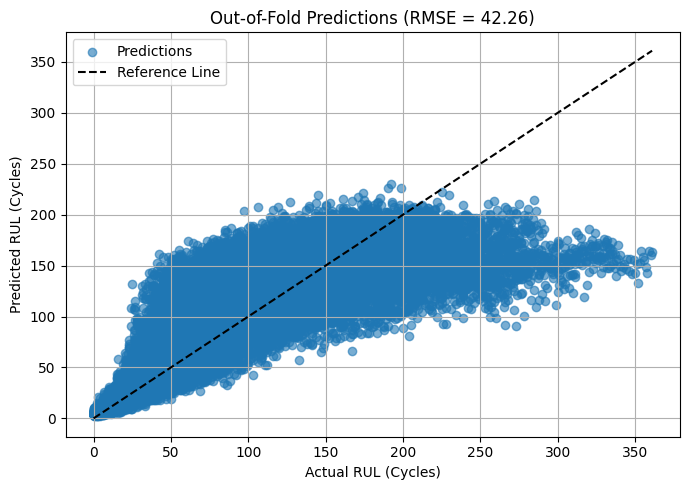

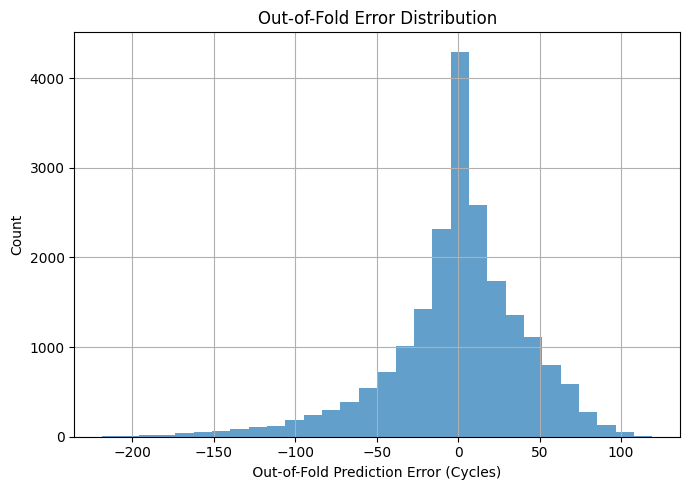

In [1]:
#XGBOOST MODEL

import os
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


data_folder = "/kaggle/input/cmap-set/CMaps"
columns = (
    ["engine_id", "time_in_cycles"]
    + [f"op_setting_{i}" for i in range(1, 4)]
    + [f"sensor_{i}" for i in range(1, 22)]
)

def load_cmaps_data(filename):
    file_path = os.path.join(data_folder, filename)
    df = pd.read_csv(file_path, sep=r"\s+", header=None, names=columns, engine="python")
    return df

df_FD001 = load_cmaps_data("train_FD001.txt")

max_cycles = df_FD001.groupby("engine_id")["time_in_cycles"].max()
df_FD001 = df_FD001.merge(max_cycles.rename("max_cycles"), on="engine_id")
df_FD001["RUL"] = df_FD001["max_cycles"] - df_FD001["time_in_cycles"]
df_FD001.drop(columns=["max_cycles"], inplace=True)

feature_cols = [
    c for c in df_FD001.columns
    if c not in ["engine_id", "time_in_cycles", "RUL"]
]
X = df_FD001[feature_cols]
y = df_FD001["RUL"]
groups = df_FD001["engine_id"]


n_splits = 10
gkf = GroupKFold(n_splits=n_splits)

oof_preds = np.zeros(len(X))  
oof_actuals = np.zeros(len(X))

train_rmse_scores = []
val_rmse_scores = []

fold = 1

for train_idx, val_idx in gkf.split(X, y, groups=groups):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    model = xgb.XGBRegressor(
        n_estimators=500,
        learning_rate=0.0116,
        max_depth=6,
        subsample=0.7291,
        colsample_bytree=0.6071,
        reg_alpha=0.00048,
        reg_lambda=0.00526,
        objective="reg:squarederror",
        tree_method="hist",
        # device="cuda",  
        random_state=42
    )
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    train_rmse_scores.append(train_rmse)

    y_val_pred = model.predict(X_val)
    val_rmse = mean_squared_error(y_val, y_val_pred, squared=False)
    val_rmse_scores.append(val_rmse)

    oof_preds[val_idx] = y_val_pred
    oof_actuals[val_idx] = y_val.values
    
    print(f"Fold {fold}: TRAIN RMSE = {train_rmse:.2f}, VAL RMSE = {val_rmse:.2f}")
    fold += 1

print("=" * 50)
mean_train_rmse = np.mean(train_rmse_scores)
mean_val_rmse = np.mean(val_rmse_scores)
print(f"Average TRAIN RMSE across folds: {mean_train_rmse:.2f}")
print(f"Average VAL   RMSE across folds: {mean_val_rmse:.2f}")


plt.figure(figsize=(7, 5))
width = 0.35
folds_range = range(1, n_splits + 1)

plt.bar([f - width/2 for f in folds_range], train_rmse_scores, width=width, label='Train RMSE')
plt.bar([f + width/2 for f in folds_range], val_rmse_scores, width=width, label='Val RMSE')

plt.title("Train vs. Validation RMSE by Fold")
plt.xlabel("Fold")
plt.ylabel("RMSE (Cycles)")
plt.xticks(folds_range)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


overall_oof_rmse = mean_squared_error(oof_actuals, oof_preds, squared=False)
print(f"\nFinal Out-of-Fold RMSE (all data): {overall_oof_rmse:.2f}")

plt.figure(figsize=(7, 5))
plt.scatter(oof_actuals, oof_preds, alpha=0.6)
min_val = min(oof_actuals.min(), oof_preds.min())
max_val = max(oof_actuals.max(), oof_preds.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--')
plt.xlabel("Actual RUL (Cycles)")
plt.ylabel("Predicted RUL (Cycles)")
plt.title(f"Out-of-Fold Predictions (RMSE = {overall_oof_rmse:.2f})")
plt.grid(True)
plt.tight_layout()
plt.show()
plt.figure(figsize=(7, 5))
plt.scatter(oof_actuals, oof_preds, alpha=0.6, label="Predictions")
min_val = min(oof_actuals.min(), oof_preds.min())
max_val = max(oof_actuals.max(), oof_preds.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', label="Reference Line")
plt.xlabel("Actual RUL (Cycles)")
plt.ylabel("Predicted RUL (Cycles)")
plt.title(f"Out-of-Fold Predictions (RMSE = {overall_oof_rmse:.2f})")
plt.grid(True)
plt.legend()  # Display the legend on the plot
plt.tight_layout()
plt.show()
# Error Distribution
errors = oof_preds - oof_actuals
plt.figure(figsize=(7, 5))
plt.hist(errors, bins=30, alpha=0.7)
plt.xlabel(" Out-of-Fold Prediction Error (Cycles) ")
plt.ylabel("Count")
plt.title("Out-of-Fold Error Distribution")
plt.grid(True)
plt.tight_layout()
plt.show()


100%|===================| 20615/20631 [10:30<00:00]        

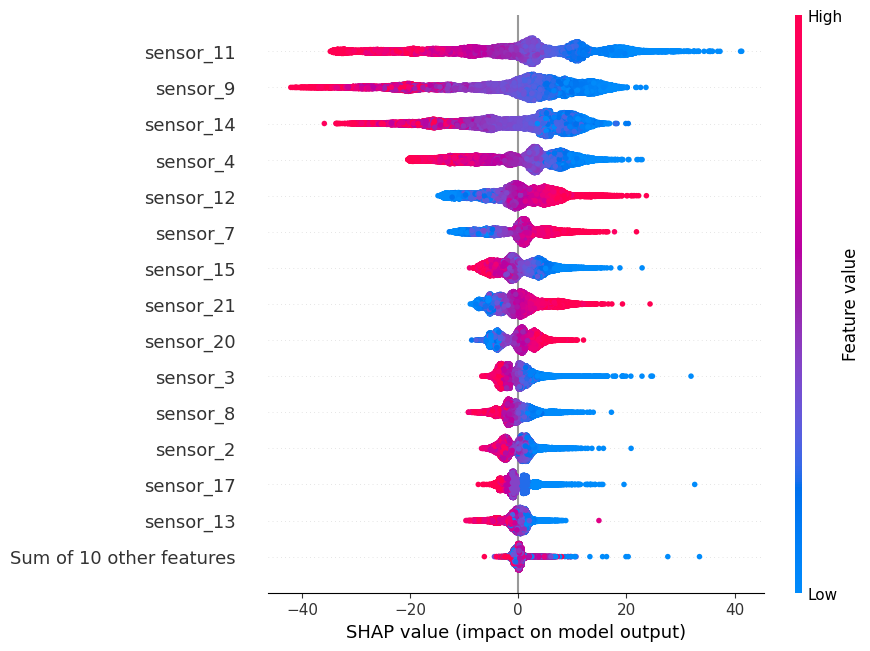

In [63]:
import shap

final_model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.0116,
    max_depth=6,
    subsample=0.7291,
    colsample_bytree=0.6071,
    reg_alpha=0.00048,
    reg_lambda=0.00526,
    objective="reg:squarederror",
    device="cuda", 
    tree_method="hist",
    
    random_state=42
)
final_model.fit(X, y)

explainer = shap.Explainer(final_model, X)

shap_values = explainer(X)

shap.plots.beeswarm(shap_values)


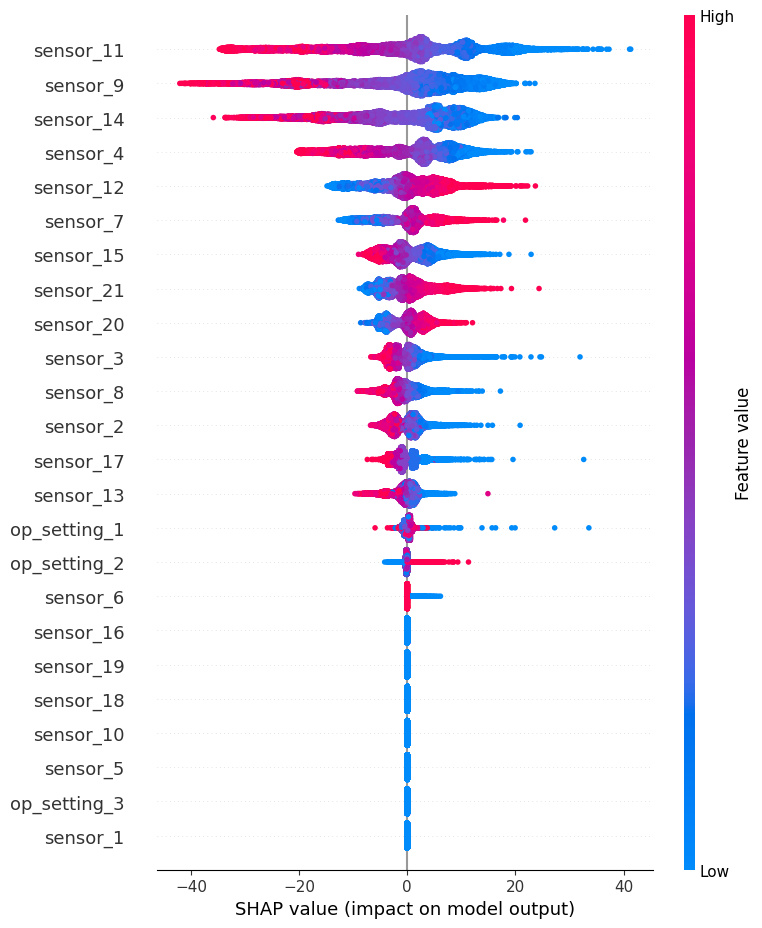

In [66]:
shap.plots.beeswarm(shap_values, max_display=len(X.columns))


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

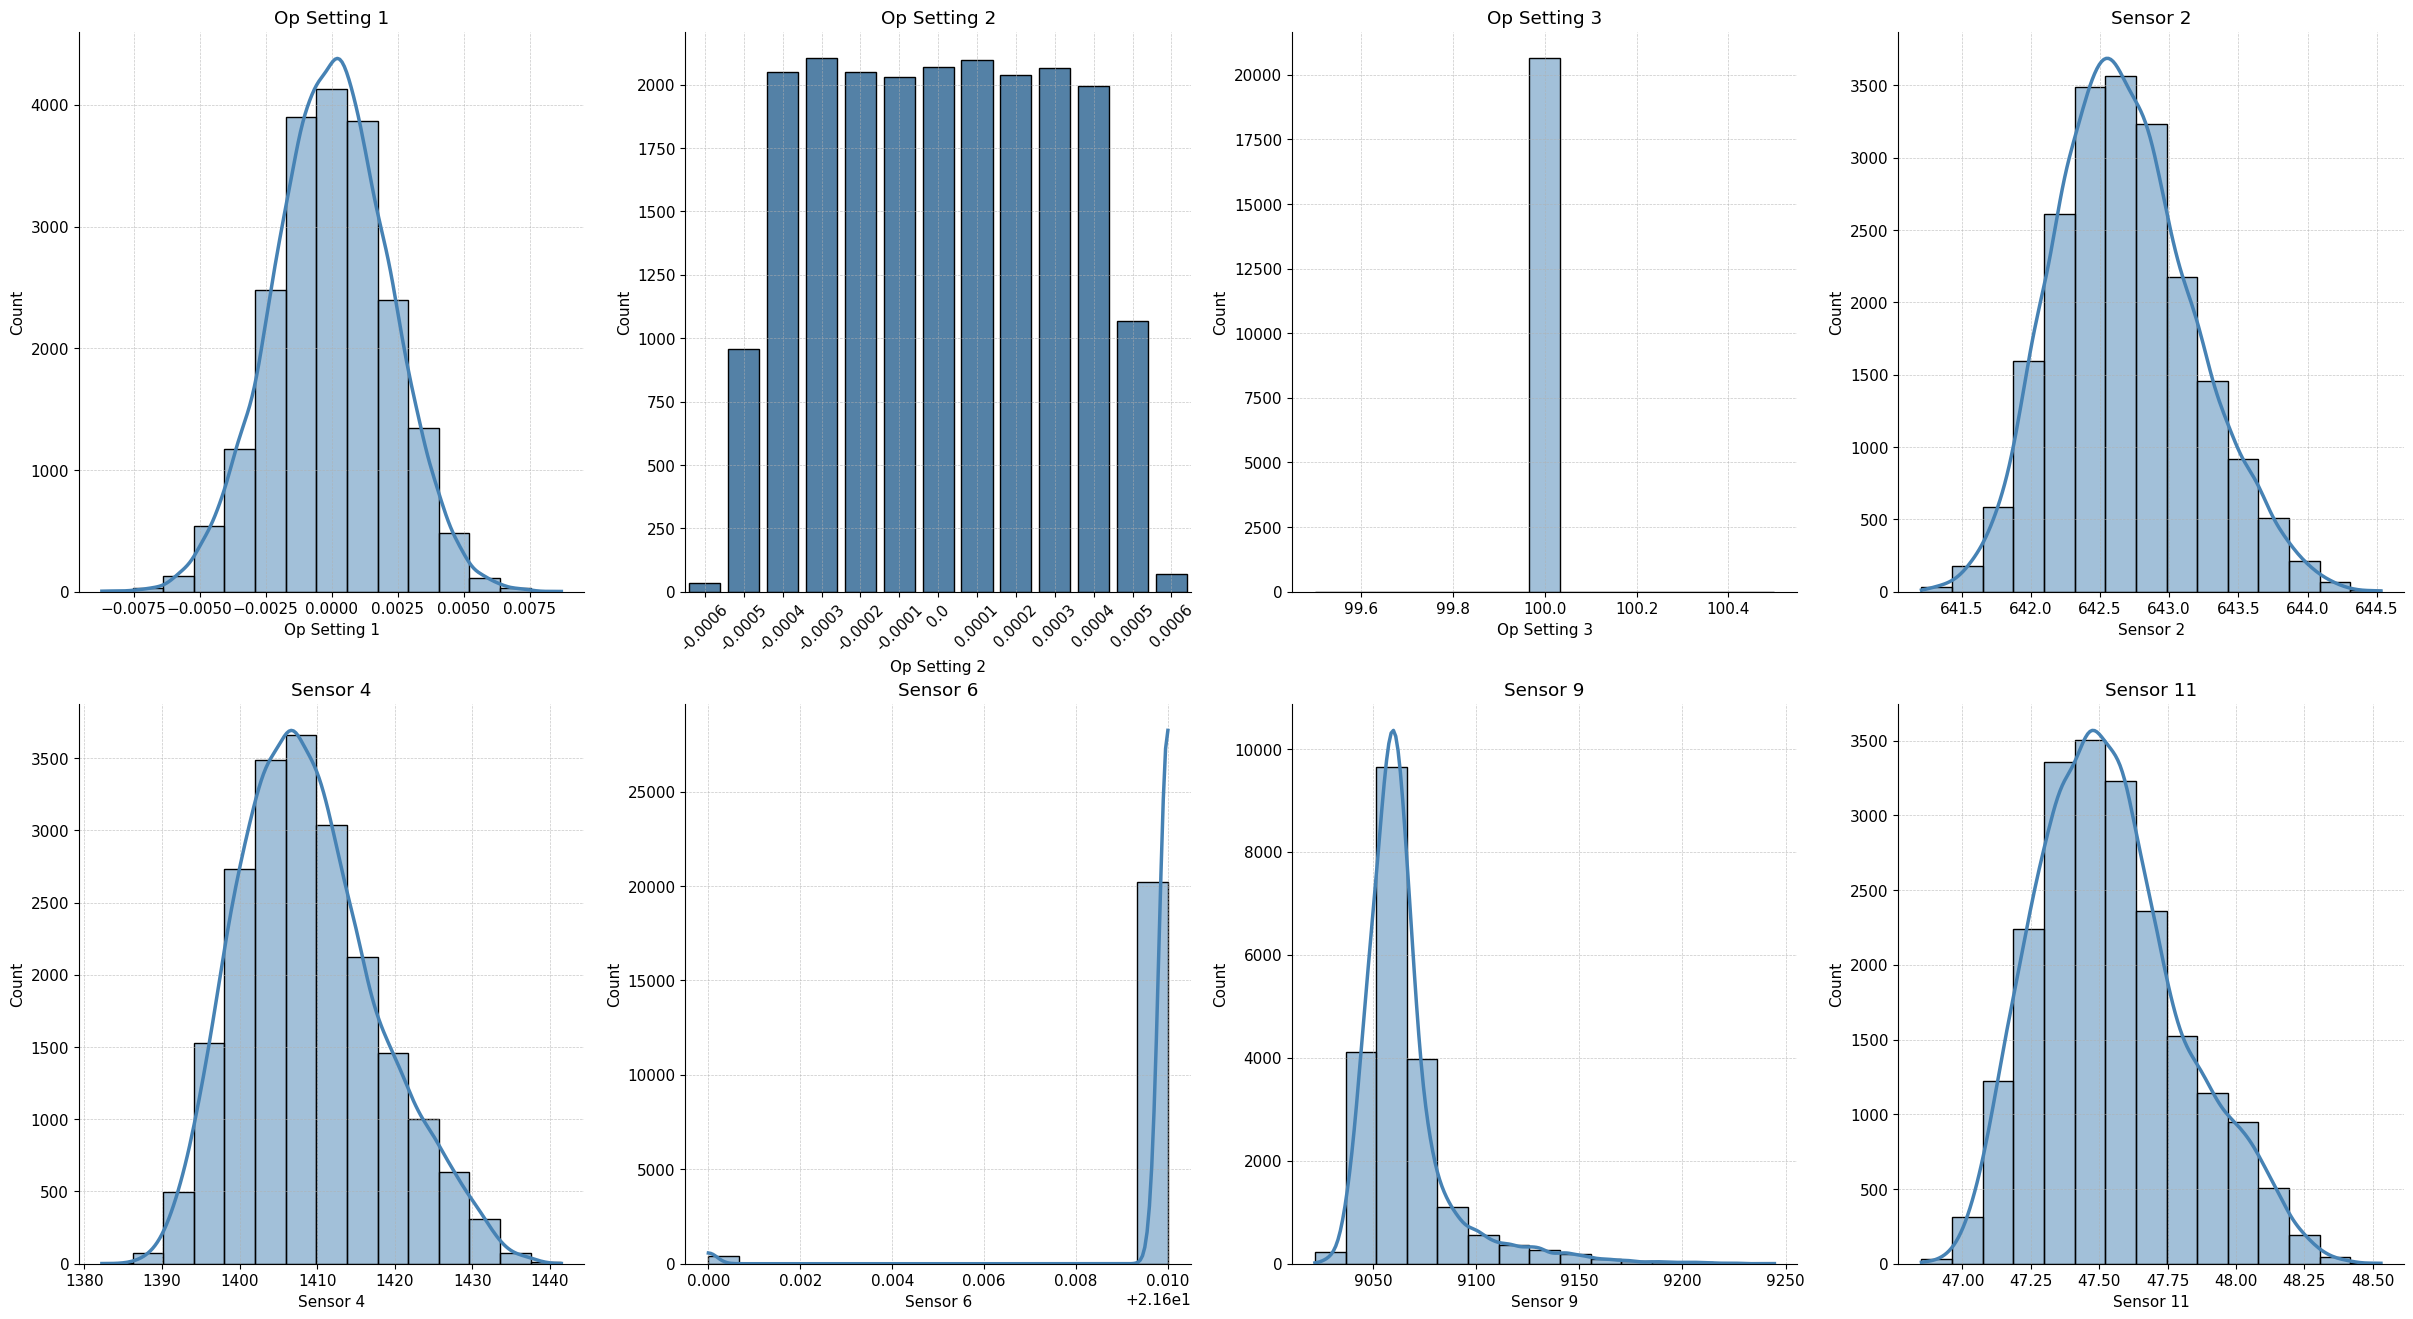

In [62]:
#EDA Exploratory data analysis 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({
    'font.family': 'sans-serif', 
    'font.size': 11
})

eight_cols = [
    "op_setting_1",
    "op_setting_2",
    "op_setting_3",
    "sensor_2",
  #  "sensor_3",
    "sensor_4",
    "sensor_6",
    "sensor_9",
    "sensor_11",
   # "sensor_14",
]

fig, axes = plt.subplots(2, 4, figsize=(30, 16))
axes = axes.flatten()

for i, col in enumerate(eight_cols):
    ax = axes[i]
    data = df_FD001[col].dropna()

    if col == "op_setting_2":
        sns.countplot(
            x=data,
            ax=ax,
            color="steelblue",
            edgecolor='black'
        )
        ax.tick_params(axis='x', rotation=45)  

    else:
        sns.histplot(
            data,
            kde=True,
            bins=15,
            ax=ax,
            edgecolor='black',
            color="steelblue",
            line_kws={'linewidth': 2.5, 'color': 'darkorange'}
        )

    ax.set_title(col.replace("_", " ").title())
    ax.set_xlabel(col.replace("_", " ").title())
    ax.set_ylabel("Count")
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
    sns.despine(ax=ax)


In [ ]:
# optuna trained
import os
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold, train_test_split
import optuna

data_folder = "/kaggle/input/cmap-set/CMaps"
columns = (
    ["engine_id", "time_in_cycles"] +
    [f"op_setting_{i}" for i in range(1, 4)] +
    [f"sensor_{i}" for i in range(1, 22)]
)

def load_cmaps_data(filename):
    file_path = os.path.join(data_folder, filename)
    df = pd.read_csv(file_path, sep=r"\s+", header=None, names=columns, engine="python")
    return df

df_FD001_train = load_cmaps_data("train_FD001.txt")

max_cycles_train = df_FD001_train.groupby("engine_id")["time_in_cycles"].max()
df_FD001_train = df_FD001_train.merge(max_cycles_train.rename("max_cycles"), on="engine_id")
df_FD001_train["RUL"] = df_FD001_train["max_cycles"] - df_FD001_train["time_in_cycles"]
df_FD001_train.drop(columns=["max_cycles"], inplace=True)

print("First few rows with RUL computed:")
print(df_FD001_train.head())


feature_columns = [col for col in df_FD001_train.columns if col not in ["engine_id", "time_in_cycles", "RUL"]]
X = df_FD001_train[feature_columns]
y = df_FD001_train["RUL"]
groups = df_FD001_train["engine_id"]


def objective(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 600),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.005, 0.02),
        "max_depth": trial.suggest_int("max_depth", 4, 10),
        "subsample": trial.suggest_float("subsample", 0.6, 0.9),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 0.9),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 1e-3),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-3, 1e-1),
        "objective": "reg:squarederror",
        "tree_method": "hist", 
        "device": "cuda",       
        "random_state": 42
    }
    
    group_kfold = GroupKFold(n_splits=5)
    rmse_list = []
    for train_idx, val_idx in group_kfold.split(X, y, groups):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        model = xgb.XGBRegressor(**param)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_list.append(rmse)
    
    return np.mean(rmse_list)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

print("Best Hyperparameters:")
print(study.best_params)
print("Best Mean RMSE from Optuna:", study.best_value)


In [12]:
#LTSM v1
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.optimizers import Adam


tf.random.set_seed(42)
np.random.seed(42)


window_size = 70        
lstm_units = 64         
learning_rate = 0.001  
batch_size = 64        
num_epochs = 75         

data_folder = "/kaggle/input/cmap-set/CMaps"  
columns = (
    ["engine_id", "time_in_cycles"] +
    [f"op_setting_{i}" for i in range(1, 4)] +
    [f"sensor_{i}" for i in range(1, 22)]
)

def load_cmaps_data(filename):
 
    file_path = os.path.join(data_folder, filename)
    df = pd.read_csv(
        file_path,
        sep=r"\s+",      
        header=None,        
        names=columns,      
        engine="python"   
    )
    return df

df_FD001_train = load_cmaps_data("train_FD001.txt")


max_cycles = df_FD001_train.groupby("engine_id")["time_in_cycles"].max()
df_FD001_train = df_FD001_train.merge(
    max_cycles.rename("max_cycles"),
    on="engine_id"
)
# Remaining Useful Life = max_cycles - current cycle
df_FD001_train["RUL"] = (
    df_FD001_train["max_cycles"] - df_FD001_train["time_in_cycles"]
)
df_FD001_train.drop(columns=["max_cycles"], inplace=True)

print("First few rows with RUL:")
print(df_FD001_train.head())

sensor_cols = [c for c in df_FD001_train.columns if c.startswith("sensor_")]
scaler = StandardScaler()
df_FD001_train[sensor_cols] = scaler.fit_transform(
    df_FD001_train[sensor_cols]
)


def window(df, window_size, feature_cols, target_col):
    X, y, groups = [], [], []
    for engine_id, grp in df.groupby("engine_id"):
        grp = grp.sort_values("time_in_cycles")
        data = grp[feature_cols].values
        targets = grp[target_col].values
        n_windows = len(grp) - window_size + 1
        if n_windows <= 0:
            continue
        for i in range(n_windows):
            X.append(data[i : i + window_size])
            y.append(targets[i + window_size - 1])
            groups.append(engine_id)
    return np.array(X), np.array(y), np.array(groups)

feature_columns = [c for c in df_FD001_train.columns
                   if c not in ["engine_id", "time_in_cycles", "RUL"]]
X_windows, y_windows, window_engine_ids = window(
    df_FD001_train, window_size, feature_columns, "RUL"
)
print(f"Created {X_windows.shape[0]} windows, each of shape {X_windows.shape[1:]}.")


gss = GroupShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
fold_rmse = []

def trim_to_multiple(arr, batch):
 
    rem = arr.shape[0] % batch
    return arr if rem == 0 else arr[:-rem]

for fold, (train_idx, val_idx) in enumerate(
    gss.split(X_windows, y_windows, groups=window_engine_ids)
):
    print(f"\n=== Fold {fold+1} ===")
    X_train, X_val = X_windows[train_idx], X_windows[val_idx]
    y_train, y_val = y_windows[train_idx], y_windows[val_idx]
    y_train, y_val = np.squeeze(y_train), np.squeeze(y_val)
    X_train = trim_to_multiple(X_train, batch_size)
    y_train = trim_to_multiple(y_train, batch_size)
    X_val   = trim_to_multiple(X_val, batch_size)
    y_val   = trim_to_multiple(y_val, batch_size)
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_ds = train_ds.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
    val_ds   = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    val_ds   = val_ds.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

    strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
    with strategy.scope():
        model = Sequential([
            Input(shape=(window_size, len(feature_columns))),  # model input
            LSTM(lstm_units, return_sequences=True),           # first LSTM
            LSTM(lstm_units),                                  # second LSTM
            Dense(2)  # outputs: lower & upper quantile predictions
        ])

        def composite_quantile_loss(y_true, y_pred):
           
            q_low, q_high = 0.1, 0.9
            y_true = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
            y_l, y_h = y_pred[:, 0], y_pred[:, 1]
            err_l, err_h = y_true - y_l, y_true - y_h
            loss_l = tf.reduce_mean(tf.maximum(q_low * err_l, (q_low - 1) * err_l))
            loss_h = tf.reduce_mean(tf.maximum(q_high * err_h, (q_high - 1) * err_h))
            return loss_l + loss_h

        def point_mae(y_true, y_pred):
         
            y_true = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
            pred_point = tf.reduce_mean(y_pred, axis=1)
            return tf.reduce_mean(tf.abs(y_true - pred_point))

        model.compile(
            optimizer=Adam(learning_rate=learning_rate),
            loss=composite_quantile_loss,
            metrics=[RootMeanSquaredError(name="rmse")]
        )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=num_epochs,
        verbose=2
    )

  
    y_pred_q = model.predict(val_ds)
    y_pred_pt = np.mean(y_pred_q, axis=1)
    y_true_all = np.concatenate([y for x, y in val_ds], axis=0)
    rmse = np.sqrt(np.mean((y_true_all - y_pred_pt) ** 2))
    fold_rmse.append(rmse)
    print(f"Fold {fold+1} RMSE: {rmse:.4f}")

print("\nAll fold RMSEs:", fold_rmse)
print(f"Mean RMSE: {np.mean(fold_rmse):.4f}")
print(f"Std RMSE:  {np.std(fold_rmse):.4f}")

# Notes:
# - y_pred_q[:,0] = lower (10th percentile)
# - y_pred_q[:,1] = upper (90th percentile)

First few rows with RUL:
   engine_id  time_in_cycles  op_setting_1  op_setting_2  op_setting_3  \
0          1               1       -0.0007       -0.0004         100.0   
1          1               2        0.0019       -0.0003         100.0   
2          1               3       -0.0043        0.0003         100.0   
3          1               4        0.0007        0.0000         100.0   
4          1               5       -0.0019       -0.0002         100.0   

   sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  ...  sensor_13  \
0    518.67    641.82   1589.70   1400.60     14.62  ...    2388.02   
1    518.67    642.15   1591.82   1403.14     14.62  ...    2388.07   
2    518.67    642.35   1587.99   1404.20     14.62  ...    2388.03   
3    518.67    642.35   1582.79   1401.87     14.62  ...    2388.08   
4    518.67    642.37   1582.85   1406.22     14.62  ...    2388.04   

   sensor_14  sensor_15  sensor_16  sensor_17  sensor_18  sensor_19  \
0    8138.62     8.4195       0.

In [2]:
#v1 cont
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import backend as K



tf.random.set_seed(42)
np.random.seed(42)

window_size   = 70       
lstm_units    = 64       
learning_rate = 0.001
batch_size    = 64
num_epochs    = 110
warmup_epochs = 40       
data_folder   = "/kaggle/input/cmap-set/CMaps"

columns = (["engine_id", "time_in_cycles"]
           + [f"op_setting_{i}" for i in range(1, 4)]
           + [f"sensor_{i}" for i in range(1, 22)])

def load_cmaps_data(filename):
    """Load C-MAPSS data and compute Remaining Useful Life (RUL)."""
    df = pd.read_csv(
        os.path.join(data_folder, filename),
        sep=r"\s+",
        header=None,
        names=columns,
        engine="python"
    )
    max_cycles = df.groupby("engine_id")["time_in_cycles"] \
                   .max().rename("max_cycles")
    df = df.merge(max_cycles, on="engine_id")
    df["RUL"] = df["max_cycles"] - df["time_in_cycles"]
    return df.drop(columns=["max_cycles"])

df = load_cmaps_data("train_FD001.txt")
sensor_cols = [c for c in df.columns if c.startswith("sensor_")]
scaler = StandardScaler()
df[sensor_cols] = scaler.fit_transform(df[sensor_cols])

feature_columns = [c for c in df.columns if c not in ["engine_id", "RUL"]]

def window(df, window_size, feature_cols, target_col):
    """Convert time-series data into sliding windows."""
    X, y, groups = [], [], []
    for eid, grp in df.groupby("engine_id"):
        grp = grp.sort_values("time_in_cycles")
        data = grp[feature_cols].values
        targ = grp[target_col].values
        pad_data = np.repeat(data[0:1], window_size - 1, axis=0)
        pad_targ = np.repeat(targ[0], window_size - 1)
        data_pad = np.vstack([pad_data, data])
        targ_pad = np.concatenate([pad_targ, targ])
        for i in range(len(data)):
            X.append(data_pad[i : i + window_size])
            y.append(targ_pad[i + window_size - 1])
            groups.append(eid)
    return np.array(X), np.array(y), np.array(groups)

X_windows, y_windows, groups = window(df, window_size, feature_columns, "RUL")

def trim(arr):
    """Trim array to a multiple of batch_size."""
    return arr[: (len(arr) // batch_size) * batch_size]

def qloss(y_true, y_pred):
    ql, qh = 0.1, 0.9
    y = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    yl, yh = y_pred[:, 0], y_pred[:, 1]
    el, eh = y - yl, y - yh
    loss_l = tf.maximum(ql * el, (ql - 1) * el)
    loss_h = tf.maximum(qh * eh, (qh - 1) * eh)
    return tf.reduce_mean(loss_l) + tf.reduce_mean(loss_h)

def point_rmse(y_true, y_pred):
    y = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pt = tf.reduce_mean(y_pred, axis=1)
    return tf.sqrt(tf.reduce_mean((y - y_pt) ** 2))

def point_mae(y_true, y_pred):
    y = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pt = tf.reduce_mean(y_pred, axis=1)
    return tf.reduce_mean(tf.abs(y - y_pt))

def lr_schedule(epoch, lr):
    """Linear warm-up for first warmup_epochs, then constant."""
    if epoch < warmup_epochs:
        return learning_rate * (epoch + 1) / warmup_epochs
    return learning_rate

lr_callback = LearningRateScheduler(lr_schedule)


gss = GroupShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
train_scores, val_scores = [], []

for fold, (train_idx, val_idx) in enumerate(
    gss.split(X_windows, y_windows, groups=groups),
    start=1
):
    print(f"\nStarting Fold {fold}")
    X_tr, y_tr = trim(X_windows[train_idx]), trim(y_windows[train_idx])
    X_val, y_val = trim(X_windows[val_idx]), trim(y_windows[val_idx])

    train_ds = tf.data.Dataset.from_tensor_slices((X_tr, y_tr)) \
        .batch(batch_size, drop_remainder=True) \
        .prefetch(tf.data.AUTOTUNE)
    val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)) \
        .batch(batch_size, drop_remainder=True) \
        .prefetch(tf.data.AUTOTUNE)

    with tf.distribute.OneDeviceStrategy(device="/gpu:0").scope():
        model = Sequential([
            Input(shape=(window_size, len(feature_columns))),
            LSTM(lstm_units, return_sequences=True,
                 kernel_regularizer=regularizers.l2(1e-4)),
            Dropout(0.2),
            LSTM(lstm_units, kernel_regularizer=regularizers.l2(1e-4)),
            Dropout(0.2),
            Dense(2)
        ])
        model.compile(
            optimizer=Adam(learning_rate),
            loss=qloss,
            metrics=[point_mae, point_rmse]
        )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=num_epochs,
        callbacks=[lr_callback],
        verbose=2
    )

    train_hist = history.history['point_rmse']
    val_hist   = history.history['val_point_rmse']

    tr_post = train_hist[warmup_epochs:]
    vl_post = val_hist[warmup_epochs:]

    best_train = np.min(tr_post) if tr_post else np.min(train_hist)
    best_val   = np.min(vl_post) if vl_post else np.min(val_hist)

    print(f"Fold {fold} — Best Train RMSE (post-warmup): {best_train:.4f}")
    print(f"Fold {fold} — Best Val   RMSE (post-warmup): {best_val:.4f}")

    train_scores.append(best_train)
    val_scores.append(best_val)

    K.clear_session()



results_df = pd.DataFrame({
    'fold':       range(1, len(train_scores) + 1),
    'train_rmse': train_scores,
    'val_rmse':   val_scores
})

print("\nPer-Fold Results:")
print(results_df.to_string(index=False))

print(f"\nCV Results — Mean Train RMSE: {np.mean(train_scores):.4f}, "
      f"Std: {np.std(train_scores):.4f}")
print(f"CV Results — Mean Val   RMSE: {np.mean(val_scores):.4f}, "
      f"Std: {np.std(val_scores):.4f}")




Starting Fold 1
Epoch 1/110
258/258 - 4s - 17ms/step - loss: 107.9390 - point_mae: 108.2000 - point_rmse: 117.2614 - val_loss: 104.5314 - val_point_mae: 105.2512 - val_point_rmse: 113.8511 - learning_rate: 2.5000e-05
Epoch 2/110
258/258 - 3s - 13ms/step - loss: 103.9908 - point_mae: 105.9087 - point_rmse: 115.1353 - val_loss: 99.0061 - val_point_mae: 101.8947 - val_point_rmse: 110.7042 - learning_rate: 5.0000e-05
Epoch 3/110
258/258 - 3s - 13ms/step - loss: 99.1935 - point_mae: 102.6366 - point_rmse: 112.0284 - val_loss: 95.3960 - val_point_mae: 99.1408 - val_point_rmse: 108.0557 - learning_rate: 7.5000e-05
Epoch 4/110
258/258 - 3s - 13ms/step - loss: 96.5740 - point_mae: 100.4676 - point_rmse: 109.9234 - val_loss: 93.1830 - val_point_mae: 97.1971 - val_point_rmse: 106.1485 - learning_rate: 1.0000e-04
Epoch 5/110
258/258 - 3s - 13ms/step - loss: 94.4049 - point_mae: 98.4973 - point_rmse: 107.9767 - val_loss: 90.9740 - val_point_mae: 95.1519 - val_point_rmse: 104.1086 - learning_rate: 

In [61]:
print(f"CV Results — Mean best RMSE: {mean_rmse:.4f}, Std: {std_rmse:.4f}")


CV Results — Mean best RMSE: 25.4462, Std: 3.1957


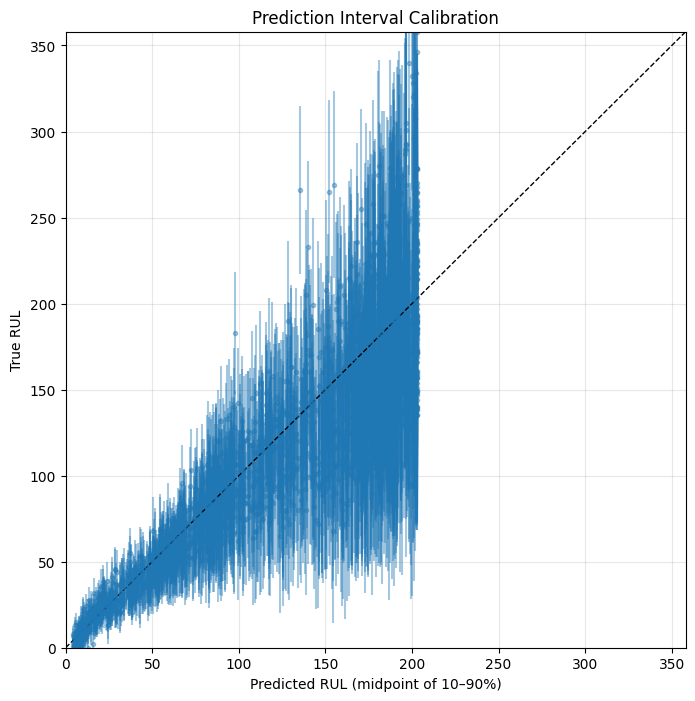

Coverage of 10–90% band: 86.99% (should be ~80%)


In [71]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

X_all = trim(X_windows)     
y_all = trim(y_windows)
q_all = model.predict(X_all, verbose=0)  

df_preds = pd.DataFrame({
    'y_true': y_all,
    'y_lo'  : q_all[:, 0],
    'y_hi'  : q_all[:, 1],
})
df_preds['y_med'] = 0.5 * (df_preds['y_lo'] + df_preds['y_hi'])

N = 2000
df_plot = df_preds.sample(n=min(N, len(df_preds)), random_state=42)

plt.figure(figsize=(8,8))
plt.errorbar(
    df_plot['y_med'], df_plot['y_true'],
    yerr=[
        df_plot['y_med'] - df_plot['y_lo'],
        df_plot['y_hi']  - df_plot['y_med']
    ],
    fmt='o', ms=3, alpha=0.4
)
lims = [0, max(df_plot['y_true'].max(), df_plot['y_med'].max())]
plt.plot(lims, lims, 'k--', linewidth=1)
plt.xlim(lims); plt.ylim(lims)

plt.xlabel('Predicted RUL (midpoint of 10–90%)')
plt.ylabel('True RUL')
plt.title('Prediction Interval Calibration')
plt.grid(alpha=0.3)
plt.show()

inside = ((df_preds['y_true'] >= df_preds['y_lo']) &
          (df_preds['y_true'] <= df_preds['y_hi']))
coverage = inside.mean()
print(f"Coverage of 10–90% band: {coverage:.2%} (should be ~80%)")


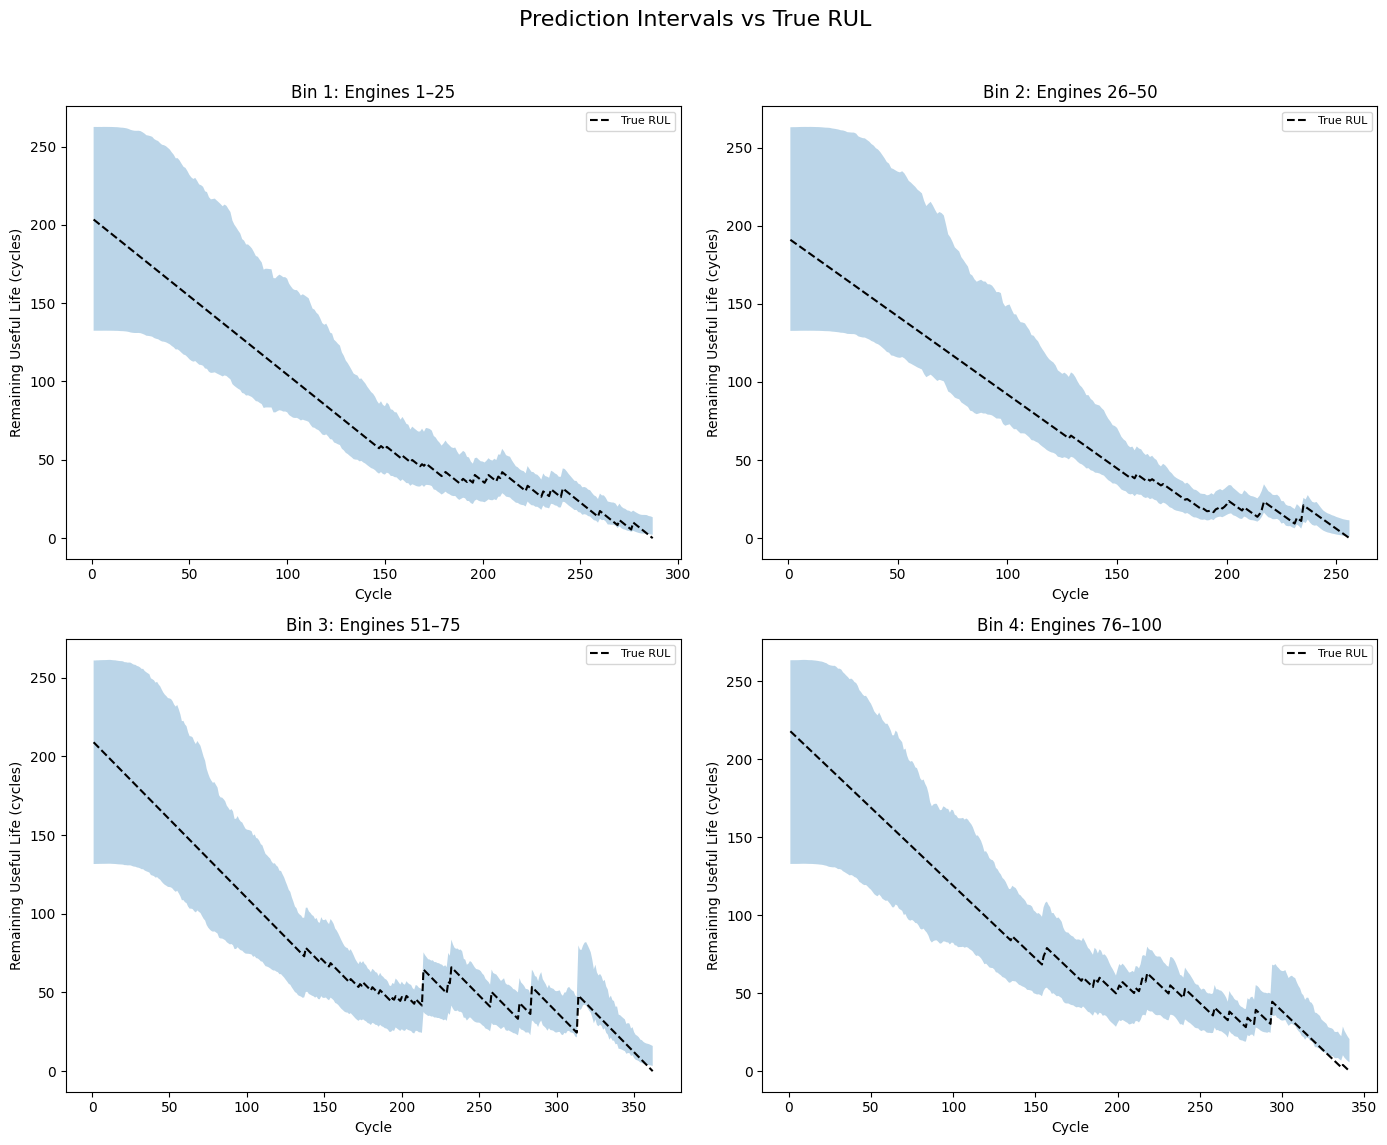

In [74]:
import numpy as np
import matplotlib.pyplot as plt

engine_ids = sorted(df["engine_id"].unique())
n_bins    = 4
bin_size  = len(engine_ids) // n_bins
bins      = [engine_ids[i*bin_size:(i+1)*bin_size] for i in range(n_bins)]

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for ax, (bin_idx, bin_ids) in zip(axes, enumerate(bins, start=1)):
    lower_by_cycle = {}
    upper_by_cycle = {}
    true_by_cycle  = {}

    for eid in bin_ids:
        grp = df[df["engine_id"] == eid].sort_values("time_in_cycles")
        X_seq = []
        data  = grp[feature_columns].values
        pad   = np.repeat(data[:1], window_size-1, axis=0)
        data  = np.vstack([pad, data])

        for i in range(len(grp)):
            X_seq.append(data[i : i+window_size])
        X_seq = np.stack(X_seq)

        q_preds = model.predict(X_seq, verbose=0)
        l, u    = q_preds[:,0], q_preds[:,1]
        cycles  = grp["time_in_cycles"].values
        true_r  = grp["RUL"].values

        for c, lt, ut, tr in zip(cycles, l, u, true_r):
            lower_by_cycle.setdefault(c, []).append(lt)
            upper_by_cycle.setdefault(c, []).append(ut)
            true_by_cycle .setdefault(c, []).append(tr)

    cycles_sorted = sorted(true_by_cycle.keys())
    mean_lo = [np.mean(lower_by_cycle[c]) for c in cycles_sorted]
    mean_hi = [np.mean(upper_by_cycle[c]) for c in cycles_sorted]
    mean_tr = [np.mean(true_by_cycle[c])  for c in cycles_sorted]

    ax.fill_between(cycles_sorted, mean_lo, mean_hi, alpha=0.3)
    ax.plot(cycles_sorted, mean_tr, 'k--', label='True RUL')
    ax.set_title(f"Bin {bin_idx}: Engines {bin_ids[0]}–{bin_ids[-1]}")
    ax.set_xlabel("Cycle")
    ax.set_ylabel("Remaining Useful Life (cycles)")
    ax.legend(fontsize=8)

fig.suptitle("Prediction Intervals vs True RUL", fontsize=16, y=0.95)
plt.tight_layout(rect=[0,0,1,0.93])
plt.show()


In [7]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import backend as K


tf.random.set_seed(42)
np.random.seed(42)

window_size   = 20       
lstm_units    = 64       
learning_rate = 0.001
batch_size    = 64
num_epochs    = 110
warmup_epochs = 40       
data_folder   = "/kaggle/input/cmap-set/CMaps"

columns = (["engine_id", "time_in_cycles"]
           + [f"op_setting_{i}" for i in range(1, 4)]
           + [f"sensor_{i}" for i in range(1, 22)])

def load_cmaps_data(filename):
    df = pd.read_csv(
        os.path.join(data_folder, filename), sep=r"\s+", header=None,
        names=columns, engine="python"
    )
    max_cycles = df.groupby("engine_id")["time_in_cycles"].max().rename("max_cycles")
    df = df.merge(max_cycles, on="engine_id")
    df["RUL"] = df["max_cycles"] - df["time_in_cycles"]
    # ----- CHANGE: cap RUL at 150 cycles to match literature -----
    df["RUL"] = df["RUL"].clip(upper=150)
    # ------------------------------------------------------------
    return df.drop(columns=["max_cycles"])

df = load_cmaps_data("train_FD001.txt")

sensor_cols = [c for c in df.columns if c.startswith("sensor_")]
scaler = StandardScaler()
df[sensor_cols] = scaler.fit_transform(df[sensor_cols])

feature_columns = [c for c in df.columns if c not in ["engine_id","RUL"]]

def window(df, window_size, feature_cols, target_col):
    X, y, groups = [], [], []
    for eid, grp in df.groupby("engine_id"):
        grp = grp.sort_values("time_in_cycles")
        data = grp[feature_cols].values
        targ = grp[target_col].values
        pad_data = np.repeat(data[0:1], window_size-1, axis=0)
        pad_targ = np.repeat(targ[0], window_size-1)
        data_pad = np.vstack([pad_data, data])
        targ_pad = np.concatenate([pad_targ, targ])
        for i in range(len(data)):
            X.append(data_pad[i:i+window_size])
            y.append(targ_pad[i+window_size-1])
            groups.append(eid)
    return np.array(X), np.array(y), np.array(groups)

X_windows, y_windows, groups = window(df, window_size, feature_columns, "RUL")

def trim(arr):
    return arr[:len(arr)//batch_size * batch_size]

def qloss(y_true, y_pred):
    ql, qh = 0.1, 0.9
    y = tf.cast(tf.reshape(y_true,[-1]),tf.float32)
    yl, yh = y_pred[:,0], y_pred[:,1]
    el, eh = y - yl, y - yh
    return tf.reduce_mean(tf.maximum(ql*el,(ql-1)*el)) + tf.reduce_mean(tf.maximum(qh*eh,(qh-1)*eh))

def point_rmse(y_true, y_pred):
    y = tf.cast(tf.reshape(y_true,[-1]),tf.float32)
    y_pt = tf.reduce_mean(y_pred, axis=1)
    return tf.sqrt(tf.reduce_mean((y - y_pt)**2))

def point_mae(y_true, y_pred):
    y = tf.cast(tf.reshape(y_true,[-1]),tf.float32)
    y_pt = tf.reduce_mean(y_pred, axis=1)
    return tf.reduce_mean(tf.abs(y - y_pt))

#  warm-up
callbacks = [LearningRateScheduler(
    lambda epoch, lr: learning_rate*(epoch+1)/warmup_epochs if epoch < warmup_epochs else learning_rate
)]

gss = GroupShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
train_scores, val_scores = [], []

for fold, (train_idx, val_idx) in enumerate(
    gss.split(X_windows, y_windows, groups), start=1
):
    print(f"Fold {fold}")
    X_tr, y_tr = trim(X_windows[train_idx]), trim(y_windows[train_idx])
    X_val, y_val = trim(X_windows[val_idx]), trim(y_windows[val_idx])

    train_ds = tf.data.Dataset.from_tensor_slices((X_tr,y_tr))\
               .batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
    val_ds   = tf.data.Dataset.from_tensor_slices((X_val,y_val))\
               .batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

    K.clear_session()
    with tf.distribute.OneDeviceStrategy("/gpu:0").scope():
        model = Sequential([
            Input((window_size, len(feature_columns))),
            LSTM(lstm_units, return_sequences=True,
                 kernel_regularizer=regularizers.l2(1e-4)),
            Dropout(0.2),
            LSTM(lstm_units, kernel_regularizer=regularizers.l2(1e-4)),
            Dropout(0.2),
            Dense(2)
        ])
        model.compile(Adam(learning_rate), loss=qloss, metrics=[point_mae, point_rmse])

    history = model.fit(
        train_ds, validation_data=val_ds,
        epochs=num_epochs, callbacks=callbacks, verbose=2
    )

    train_rmse_hist = history.history['point_rmse'][warmup_epochs:]
    val_rmse_hist   = history.history['val_point_rmse'][warmup_epochs:]
    best_train = np.min(train_rmse_hist) if train_rmse_hist else np.min(history.history['point_rmse'])
    best_val   = np.min(val_rmse_hist)   if val_rmse_hist   else np.min(history.history['val_point_rmse'])

    print(f"  Best post-warmup Train RMSE: {best_train:.4f}")
    print(f"  Best post-warmup Val   RMSE: {best_val:.4f}")

    train_scores.append(best_train)
    val_scores.append(best_val)

print("\nCross-Validation Results:")
for i, (tr, vl) in enumerate(zip(train_scores, val_scores), start=1):
    print(f" Fold {i}: Train RMSE = {tr:.3f}, Val RMSE = {vl:.3f}")
print(f"Mean Train RMSE: {np.mean(train_scores):.3f} ± {np.std(train_scores):.3f}")
print(f"Mean Val   RMSE: {np.mean(val_scores):.3f} ± {np.std(val_scores):.3f}")

model.save('best_lstm_quantile_model2.h5')


Fold 1
Epoch 1/110
258/258 - 3s - 12ms/step - loss: 94.6846 - point_mae: 94.9350 - point_rmse: 101.5531 - val_loss: 93.4000 - val_point_mae: 93.9694 - val_point_rmse: 100.3389 - learning_rate: 2.5000e-05
Epoch 2/110
258/258 - 2s - 7ms/step - loss: 91.2904 - point_mae: 92.7160 - point_rmse: 99.4685 - val_loss: 88.7742 - val_point_mae: 90.7795 - val_point_rmse: 97.3060 - learning_rate: 5.0000e-05
Epoch 3/110
258/258 - 2s - 7ms/step - loss: 87.5558 - point_mae: 89.8687 - point_rmse: 96.7330 - val_loss: 85.8363 - val_point_mae: 88.3245 - val_point_rmse: 94.9210 - learning_rate: 7.5000e-05
Epoch 4/110
258/258 - 2s - 7ms/step - loss: 85.1743 - point_mae: 87.7523 - point_rmse: 94.6578 - val_loss: 83.7191 - val_point_mae: 86.3622 - val_point_rmse: 92.9853 - learning_rate: 1.0000e-04
Epoch 5/110
258/258 - 2s - 7ms/step - loss: 83.0592 - point_mae: 85.7930 - point_rmse: 92.7099 - val_loss: 81.5208 - val_point_mae: 84.3524 - val_point_rmse: 90.9728 - learning_rate: 1.2500e-04
Epoch 6/110
258/258 

In [9]:
#v2 cont

import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import backend as K


tf.random.set_seed(42)
np.random.seed(42)

window_size   = 40       
lstm_units    = 64      
learning_rate = 0.001
batch_size    = 64
num_epochs    = 110
warmup_epochs = 40       
data_folder   = "/kaggle/input/cmap-set/CMaps"

columns = (["engine_id", "time_in_cycles"]
           + [f"op_setting_{i}" for i in range(1, 4)]
           + [f"sensor_{i}" for i in range(1, 22)])

def load_cmaps_data(filename):
    df = pd.read_csv(
        os.path.join(data_folder, filename), sep=r"\s+", header=None,
        names=columns, engine="python"
    )
    max_cycles = df.groupby("engine_id")["time_in_cycles"].max().rename("max_cycles")
    df = df.merge(max_cycles, on="engine_id")
    df["RUL"] = df["max_cycles"] - df["time_in_cycles"]
    # ----- CHANGE: cap RUL at 150 cycles to match literature -----
    df["RUL"] = df["RUL"].clip(upper=150)
    # ------------------------------------------------------------
    return df.drop(columns=["max_cycles"])

df = load_cmaps_data("train_FD001.txt")

sensor_cols = [c for c in df.columns if c.startswith("sensor_")]
scaler = StandardScaler()
df[sensor_cols] = scaler.fit_transform(df[sensor_cols])

feature_columns = [c for c in df.columns if c not in ["engine_id","RUL"]]

def window(df, window_size, feature_cols, target_col):
    X, y, groups = [], [], []
    for eid, grp in df.groupby("engine_id"):
        grp = grp.sort_values("time_in_cycles")
        data = grp[feature_cols].values
        targ = grp[target_col].values
        pad_data = np.repeat(data[0:1], window_size-1, axis=0)
        pad_targ = np.repeat(targ[0], window_size-1)
        data_pad = np.vstack([pad_data, data])
        targ_pad = np.concatenate([pad_targ, targ])
        for i in range(len(data)):
            X.append(data_pad[i:i+window_size])
            y.append(targ_pad[i+window_size-1])
            groups.append(eid)
    return np.array(X), np.array(y), np.array(groups)

X_windows, y_windows, groups = window(df, window_size, feature_columns, "RUL")

def trim(arr):
    return arr[:len(arr)//batch_size * batch_size]

def qloss(y_true, y_pred):
    ql, qh = 0.1, 0.9
    y = tf.cast(tf.reshape(y_true,[-1]),tf.float32)
    yl, yh = y_pred[:,0], y_pred[:,1]
    el, eh = y - yl, y - yh
    return tf.reduce_mean(tf.maximum(ql*el,(ql-1)*el)) + tf.reduce_mean(tf.maximum(qh*eh,(qh-1)*eh))

def point_rmse(y_true, y_pred):
    y = tf.cast(tf.reshape(y_true,[-1]),tf.float32)
    y_pt = tf.reduce_mean(y_pred, axis=1)
    return tf.sqrt(tf.reduce_mean((y - y_pt)**2))

def point_mae(y_true, y_pred):
    y = tf.cast(tf.reshape(y_true,[-1]),tf.float32)
    y_pt = tf.reduce_mean(y_pred, axis=1)
    return tf.reduce_mean(tf.abs(y - y_pt))

callbacks = [LearningRateScheduler(
    lambda epoch, lr: learning_rate*(epoch+1)/warmup_epochs if epoch < warmup_epochs else learning_rate
)]

gss = GroupShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
train_scores, val_scores = [], []

for fold, (train_idx, val_idx) in enumerate(
    gss.split(X_windows, y_windows, groups), start=1
):
    print(f"Fold {fold}")
    X_tr, y_tr = trim(X_windows[train_idx]), trim(y_windows[train_idx])
    X_val, y_val = trim(X_windows[val_idx]), trim(y_windows[val_idx])

    train_ds = tf.data.Dataset.from_tensor_slices((X_tr,y_tr))\
               .batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
    val_ds   = tf.data.Dataset.from_tensor_slices((X_val,y_val))\
               .batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

    K.clear_session()
    with tf.distribute.OneDeviceStrategy("/gpu:0").scope():
        model = Sequential([
            Input((window_size, len(feature_columns))),
            LSTM(lstm_units, return_sequences=True,
                 kernel_regularizer=regularizers.l2(1e-4)),
            Dropout(0.2),
            LSTM(lstm_units, kernel_regularizer=regularizers.l2(1e-4)),
            Dropout(0.2),
            Dense(2)
        ])
        model.compile(Adam(learning_rate), loss=qloss, metrics=[point_mae, point_rmse])

    history = model.fit(
        train_ds, validation_data=val_ds,
        epochs=num_epochs, callbacks=callbacks, verbose=2
    )

    train_rmse_hist = history.history['point_rmse'][warmup_epochs:]
    val_rmse_hist   = history.history['val_point_rmse'][warmup_epochs:]
    best_train = np.min(train_rmse_hist) if train_rmse_hist else np.min(history.history['point_rmse'])
    best_val   = np.min(val_rmse_hist)   if val_rmse_hist   else np.min(history.history['val_point_rmse'])

    print(f"  Best post-warmup Train RMSE: {best_train:.4f}")
    print(f"  Best post-warmup Val   RMSE: {best_val:.4f}")

    train_scores.append(best_train)
    val_scores.append(best_val)

print("\nCross-Validation Results:")
for i, (tr, vl) in enumerate(zip(train_scores, val_scores), start=1):
    print(f" Fold {i}: Train RMSE = {tr:.3f}, Val RMSE = {vl:.3f}")
print(f"Mean Train RMSE: {np.mean(train_scores):.3f} ± {np.std(train_scores):.3f}")
print(f"Mean Val   RMSE: {np.mean(val_scores):.3f} ± {np.std(val_scores):.3f}")

model.save('best_lstm_quantile_model2.h5')


Fold 1
Epoch 1/110
258/258 - 3s - 13ms/step - loss: 94.6599 - point_mae: 94.9659 - point_rmse: 101.5700 - val_loss: 93.2925 - val_point_mae: 93.9311 - val_point_rmse: 100.3143 - learning_rate: 2.5000e-05
Epoch 2/110
258/258 - 2s - 9ms/step - loss: 90.8075 - point_mae: 92.4372 - point_rmse: 99.2275 - val_loss: 87.5378 - val_point_mae: 90.0801 - val_point_rmse: 96.6502 - learning_rate: 5.0000e-05
Epoch 3/110
258/258 - 2s - 9ms/step - loss: 85.9814 - point_mae: 88.9199 - point_rmse: 95.8192 - val_loss: 84.0608 - val_point_mae: 87.2199 - val_point_rmse: 93.8432 - learning_rate: 7.5000e-05
Epoch 4/110
258/258 - 2s - 9ms/step - loss: 83.2445 - point_mae: 86.4648 - point_rmse: 93.3913 - val_loss: 81.7070 - val_point_mae: 85.0028 - val_point_rmse: 91.6303 - learning_rate: 1.0000e-04
Epoch 5/110
258/258 - 2s - 9ms/step - loss: 81.0564 - point_mae: 84.4678 - point_rmse: 91.3794 - val_loss: 79.5169 - val_point_mae: 83.0600 - val_point_rmse: 89.6635 - learning_rate: 1.2500e-04
Epoch 6/110
258/258 

126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


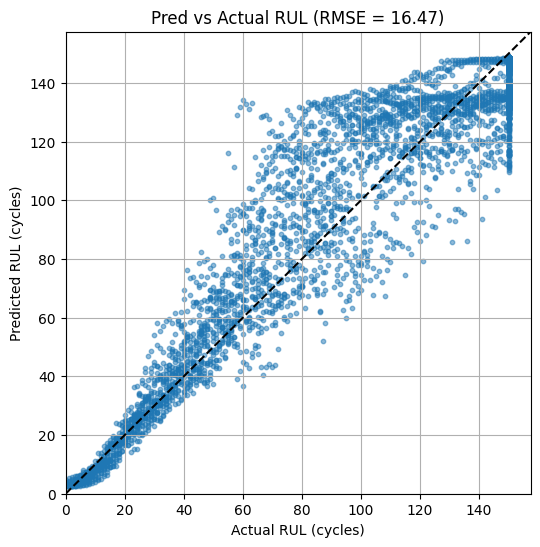

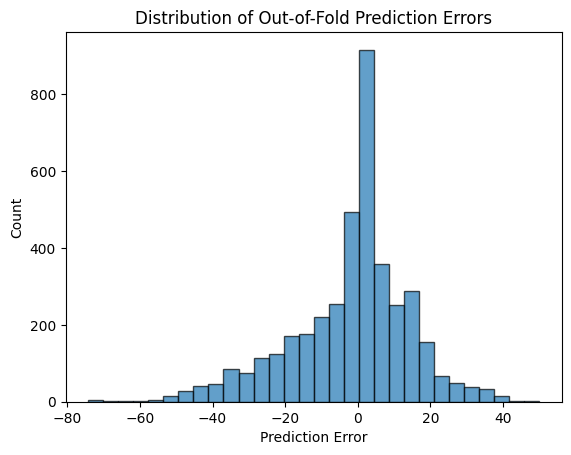

In [12]:
import matplotlib.pyplot as plt

X_all_val, y_all_val = np.concatenate([x for x,y in val_ds], axis=0), np.concatenate([y for x,y in val_ds], axis=0)
q_all = model.predict(X_all_val)
y_pred_pt = np.mean(q_all, axis=1)
errors = y_all_val - y_pred_pt

rmse = np.sqrt(np.mean(errors**2))
plt.figure(figsize=(6,6))
plt.scatter(y_all_val, y_pred_pt, s=10, alpha=0.5)
lims = [0, max(y_all_val.max(), y_pred_pt.max())*1.05]
plt.plot(lims, lims, '--', color='k')
plt.xlim(lims); plt.ylim(lims)
plt.xlabel('Actual RUL (cycles)')
plt.ylabel('Predicted RUL (cycles)')
plt.title(f'Pred vs Actual RUL (RMSE = {rmse:.2f})')
plt.grid(True)
plt.show()

plt.hist(errors, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.title('Distribution of Out-of-Fold Prediction Errors')
plt.show()
